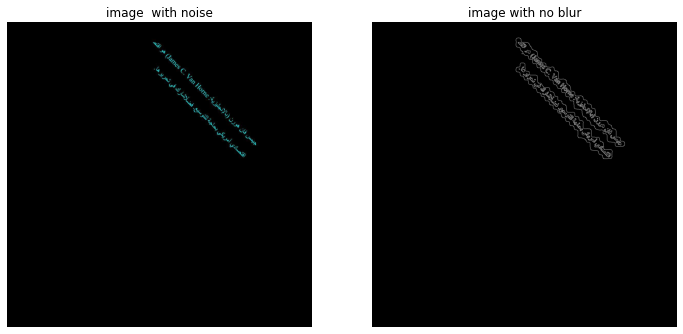

In [193]:

import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy.signal import fftconvolve
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median
from skimage.feature import canny

# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# import numpy as np

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

from PIL import Image
import io as standard_io
from scipy.ndimage import gaussian_filter
from skimage import color

# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')

    ##this function works correctly to remove the salt and pepper noise



def HistogramEqualization(img):
    gray_image = color.rgb2gray(img)

    gray_levels = 256
    N, M = gray_image.shape

    H = np.zeros(gray_levels, dtype=int)

    # Calculate the histogram
    for i in range(N):
        for j in range(M):
            gray_level = int(gray_image[i, j] * (gray_levels - 1))
            H[gray_level] += 1

    H_c = np.zeros_like(H)
    H_c[0] = H[0]

    mapping = np.zeros(gray_levels, dtype=int)
    mapping[0] = int(((gray_levels - 1) * H_c[0]) / (N * M))

    for p in range(1, gray_levels):
        H_c[p] = H_c[p - 1] + H[p]
        new_gray_level = int(((gray_levels - 1) * H_c[p]) / (N * M))
        mapping[p] = new_gray_level

    equalized_image = np.zeros_like(gray_image)

    for i in range(N):
        for j in range(M):
            gray_level = int(gray_image[i, j] * (gray_levels - 1))
            equalized_image[i, j] = mapping[gray_level]

    return equalized_image

def remove_saltpepper_noise(image, window_size=3):
    """
    Removes noise from an image using median filtering for salt and pepper noise.

    Args:
    - image: Input image (numpy array).
    - window_size: Size of the square neighborhood window for median filtering (default is 3).

    Returns:
    - Denoised image as a numpy array.
    """
    # Convert image to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    X = cv2.bilateralFilter(image_gray, 15, sigmaColor=10, sigmaSpace=10)
    # Apply median filtering for salt and pepper noise removal
    denoised_image = median(X, footprint=np.ones((window_size, window_size)))

    return denoised_image
def remove_blur(image, sigma_color=50, sigma_space=100):
    """
    Removes blur from a grayscale image using the bilateral filter.

    Args:
    - image: Input grayscale image (numpy array).
    - sigma_color: Parameter controlling the color space sigma (default is 10).
    - sigma_space: Parameter controlling the spatial sigma (default is 10).

    Returns:
    - Deblurred image as a numpy array.
    """
    # Apply bilateral filtering to remove blur
    deblurred_image = cv2.bilateralFilter(image, 5, sigma_color, sigma_space)

    return deblurred_image

def preprocess_image(image, target_size=(256, 256)):
    """
    Preprocesses an image by converting it to grayscale and resizing.

    Args:
    - image: Input image (numpy array).
    - target_size: Target size for resizing the image (default is (256, 256)).

    Returns:
    - Preprocessed image as a binary image (numpy array).
    """
    antinoise=remove_saltpepper_noise(image)
    # antinoise=image
    # Apply binary thresholding to create a binary image
    # antiblur=remove_blur(antinoise)
    _, binary_image = cv2.threshold(antinoise, 128, 255, cv2.THRESH_BINARY)
    # Resize the image to the target size
    resized_image = cv2.resize(binary_image, target_size)
    return resized_image

kernel_size=2
def unsharp_masking(image, blur_radius=5, sharpen_amount=1.0):
    """Apply unsharp masking followed by dilation to enhance image details."""
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), blur_radius)
    
    # Apply unsharp masking
    sharpened = cv2.addWeighted(image, 1.0 + sharpen_amount, blurred, -sharpen_amount, 0)
    
    # Ensure the sharpened image doesn't have values below the original image
    sharpened = np.where(image >= blurred, sharpened, image)
    
    return sharpened

def remove_noise22(image, dilation_kernel=None):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # io.imshow(gray)
    bilateral_filtered = cv2.bilateralFilter(gray, 15, sigmaColor=3, sigmaSpace=10)
    # cv2.imwrite('C:/CMP-3dYear/2d term/Nueral  Networks/project/before_image.jpeg', bilateral_filtered)
    median_blurred = cv2.medianBlur(bilateral_filtered, 3)
    # cv2.imwrite('C:/CMP-3dYear/2d term/Nueral  Networks/project/after_image.jpeg', median_blurred)
    result = unsharp_masking(median_blurred, blur_radius=10, sharpen_amount=4) * 255
    result = np.uint8(result)
    edges = cv2.Canny(result, 80, 255,apertureSize=3)
       # Optionally apply dilation
    if dilation_kernel is not None:
        # Perform dilation
        edges = cv2.dilate(edges, dilation_kernel)
    return edges


# Path to the folder containing the images
folder_path =  'C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts-dataset/IBM Plex Sans Arabic'

# # List to store preprocessed images
# preprocessed_images = []

# # Iterate through the files in the folder
# for filename in os.listdir(folder_path):
#     # Check if the file is a JPEG image
#     if filename.endswith('.jpeg') or filename.endswith('.jpg'):
#         # Read the image
#         image_path = os.path.join(folder_path, filename)
#         image = cv2.imread(image_path)
        
#         # Preprocess the image
#         preprocessed_image = preprocess_image(image)
#         # print("ok\n")
#         # Append the preprocessed image to the list
#         preprocessed_images.append(preprocessed_image)
impath='C:/CMP-3dYear/2d term/Nueral  Networks/project/0.jpeg'

image=io.imread(impath)
# io.imshow(image)
test=remove_noise22(image)
show_images([image,test],["image  with noise","image with no blur"])
# cv2.imwrite('C:/CMP-3dYear/2d term/Nueral  Networks/project/test_image.jpeg', test)





In [199]:
import os
import cv2



def construct_dataset(input_folder, output_folder):
    # Iterate over subfolders in the input folder
    for root, dirs, files in os.walk(input_folder):
        for dir_name in dirs:
            input_subfolder = os.path.join(root, dir_name)
            output_subfolder = os.path.join(output_folder, os.path.relpath(input_subfolder, input_folder))
            
            # Create corresponding subfolder in the output folder
            os.makedirs(output_subfolder, exist_ok=True)
            
            # Iterate over files in the subfolder
            for file_name in os.listdir(input_subfolder):
                input_image_path = os.path.join(input_subfolder, file_name)
                output_image_path = os.path.join(output_subfolder, file_name)
                
                # Read the image
                image = io.imread(input_image_path)
                
                # Apply preprocessing
                # np.ones((kernel_size, kernel_size), np.uint8)
                processed_image = remove_noise22(image,dilation_kernel=None)
                
                # Save the processed image
                cv2.imwrite(output_image_path, processed_image)
                print(f"Processed and saved: {output_image_path}")

# Example usage:
input_folder = "C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts-dataset/"
output_folder = "C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/"
construct_dataset(input_folder, output_folder)


Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\0.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\1.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\10.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\100.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\101.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\102.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\103.jpeg
Processed and saved: C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/IBM Plex Sans Arabic\104.jpeg
Processed and saved: C:/CMP-3

In [198]:
import cv2

# Load an image
image = cv2.imread('C:/CMP-3dYear/2d term/Nueral  Networks/project/fonts_processed-dataset/Marhey/0.jpeg')

# Create a SIFT object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)

# Draw keypoints on the original image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
cv2.imwrite('C:/CMP-3dYear/2d term/Nueral  Networks/project/image_with_keypoints.jpeg', image_with_keypoints)


True